In [1]:
from scipy.special import expit
from rbm import RBM
from sampler import VanillaSampler, PartitionedSampler, ApproximatedSampler
from trainer import VanillaTrainier
from performance import Result
import numpy as np
import datasets, performance, plotter, mnist, pickle, rbm, os, logging, sampler
from sklearn.linear_model import Perceptron

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

logger = logging.getLogger()
# Set the logging level to logging.DEBUG 
logger.setLevel(logging.INFO)


%matplotlib inline
# make one 2 bit image, both visibles on
v = np.ones(2)

# lets make our hiddens, 2 hidden units
h_a = np.zeros(2)
h_b = np.zeros(2)
h_a[0] = 1
h_a[1] = 0

h_b[0] = 0
h_b[1] = 1

# Set up our weights matrix (|h| , |v|), with perfect weights.
w_a = np.ones((2, 2))
w_b = np.ones((2, 2))
w_a[0][1] = -1
w_a[1][0] = -1
w_b[0][1] = -1
w_b[1][0] = -1

A = RBM(2,2,1)
B = RBM(2,2,1)
# manually set our RBM's
A.hidden = h_a
B.hidden = h_b
A.visible = v
B.visible = v
A.weights = w_a
B.weights = w_b
A.hidden_bias = 0.5
B.hidden_bias = 0.5
A.visible_bias = 0.5
B.visible_bias = 0.5

In [2]:
def count_matrix_for_runs(runs, model, visible):
    van_sampler = VanillaSampler(model)
    counts = {}
    for i in range(runs):

        vis = np.where(van_sampler.hidden_to_visible(van_sampler.visible_to_hidden(visible)) >= 0.5, 1, 0)
        key = np.array_str(vis)
        if key in counts:
            counts[key] = counts[key] + 1
        else:
            counts[key] = 0
    for key in counts:
        counts[key] = counts[key]/runs * 100
    
    return counts

In [3]:
# run vanilla sampling 10,000 times, getting the percentage of reconstructions for A and then B
print(count_matrix_for_runs(100, A, v))
print(count_matrix_for_runs(100, B, v))

{'[1 0]': 21.0, '[1 1]': 56.00000000000001, '[0 1]': 20.0}
{'[1 0]': 20.0, '[1 1]': 56.99999999999999, '[0 1]': 20.0}


In [4]:
def weighted_sum_into_vis(vis_idx, w,h):
    return np.dot(w.T, h)

def visible_to_hidden(visible):
    np.dot(w.T,visibe)

    
def approx_correction(h_a, h_b, w_a, w_b):
    col_hid_a = h_a.reshape(2,1)
    col_hid_b = h_b.reshape(2,1)
    phi_a = np.dot(w_a, h_a) - (w_a * col_hid_a)
    phi_b = np.dot(w_b, h_b) - (w_b * col_hid_b)
    sig_A = phi_a + w_a/2
    sig_B = phi_b + w_b/2
    epsilon_a = np.dot(w_b,h_b)
    epsilon_b = np.dot(w_a,h_a)
    sig_AB = sig_A + epsilon_a
    sig_BA = sig_B + epsilon_b
    c_a = expit(sig_A) - expit(sig_AB)
    c_b = expit(sig_B) - expit(sig_BA)
    return c_a, c_b


def p_hid(h_a, h_b, w_a, w_b, c = approx_correction):
    c_a, c_b = c(h_a, h_b, w_a, w_b)
    psi_a = (w_a * (v + c_a)).sum(1) # of course this isn't really the correction it's more of an ammendent (? word)
    psi_b = (w_b * (v + c_b)).sum(1) 
    return expit(psi_a),expit(psi_b)   

def run_partitioned_samples(hidden_a, hidden_b, weights_a, weights_b, visible,num_samples):
    for epoch in range(num_samples):

        p_hid_a, p_hid_b = p_hid(hidden_a, hidden_a, weights_a, weights_b)
        
        # now, do we turn on he hiddens? Bernoulli sample to decide
        hidden_a = np.where(p_hid_a > np.random.rand(*p_hid_a.shape),1,0) 
        hidden_b = np.where(p_hid_b > np.random.rand(*p_hid_b.shape),1,0) 

    return hidden_a, hidden_b



In [5]:
def calculate_result_dict(w_a, w_b, c = approx_correction):
    results = {}
    base_key = "h_a{} h_b{}"
    for i_a in range(2):
        for j_a in range(2):
            for i_b in range(2):
                for j_b in range(2):
                    hidden_a = np.array([j_a, i_a]) 
                    hidden_b = np.array([j_b, i_b])
                    results[base_key.format(hidden_a, hidden_b)] = p_hid(hidden_a, hidden_b, w_a, w_b,c= c)
    return results       

def probs_for_result_dict(results, hidd_counts):
    tot = 0
    for i in hidd_counts:
        tot += hidd_counts[i]
    for key in hidd_counts:
        print("{} {}% of the time. {} times out of {}.\n\tRespective Probabilities:{}\n\t".format(key, hidd_counts[key]/tot,  hidd_counts[key], tot,results[key] ))
        
    print("tot = {}".format(tot))

In [6]:
r = calculate_result_dict(w_a, w_b)
a = r['h_a[0 1] h_b[0 1]']
b = r['h_a[1 0] h_b[1 0]']
def plot_result_for_hidden_states(h_a, h_b, result_dict):
    key = 'h_a{} h_b{}'.format(h_a,h_b)
    
    kwargs = {'interpolation':'nearest','cmap':'copper', 'vmin':0, 'vmax':1}
    plt.subplot(331)
    plt.title("hA")
    plt.axis('off')
    plt.imshow(h_a.reshape((1,2)), **kwargs)
    
    plt.subplot(332)
    plt.title("hB")
    plt.axis('off')
    plt.imshow(h_b.reshape((1,2)), **kwargs)
    
    
    plt.subplot(334)
    plt.title("P(A)")
    plt.axis('off')
    plt.imshow(result_dict[key][0].reshape(1,2),**kwargs)
    
    plt.subplot(335)
    plt.title("P(B)")
    plt.axis('off')
    plt.imshow(result_dict[key][1].reshape(1,2),**kwargs)   
    plt.show()

print(a)
print(b)

(array([ 0.59633814,  0.40366186]), array([ 0.59633814,  0.40366186]))
(array([ 0.40366186,  0.59633814]), array([ 0.40366186,  0.59633814]))


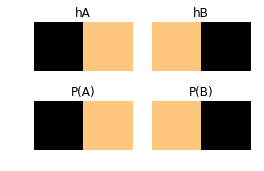

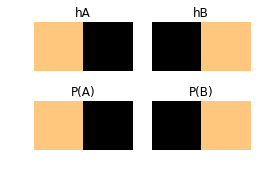

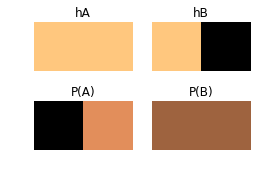

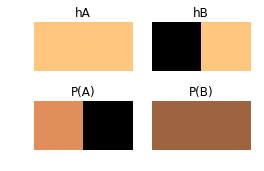

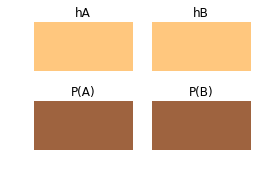

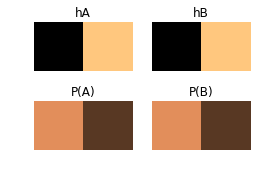

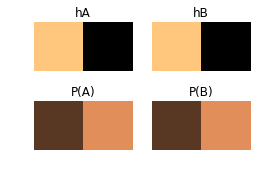

In [7]:
r = calculate_result_dict(w_a*4, w_b*4)
plot_result_for_hidden_states(np.array([0,1]),np.array([1,0]),r)
plot_result_for_hidden_states(np.array([1,0]),np.array([0,1]),r)
plot_result_for_hidden_states(np.array([1,1]),np.array([1,0]),r)
plot_result_for_hidden_states(np.array([1,1]),np.array([0,1]),r)
plot_result_for_hidden_states(np.array([1,1]),np.array([1,1]),r)
plot_result_for_hidden_states(np.array([0,1]),np.array([0,1]),r)
plot_result_for_hidden_states(np.array([1,0]),np.array([1,0]),r)


In [8]:
training_set = np.eye(2)
dot = RBM(2,2,1)
s = VanillaSampler(dot)
t = VanillaTrainier(dot, s)
t.train(10000, training_set)

In [9]:
a = ApproximatedSampler(dot.weights,dot.weights, 0,0)
a.v_to_v(np.array([1,1]), np.array([1,0]), np.array([1,1]), num_gibbs=10000)

# psi_a, psi_b = p_hid(np.array([0,1]), np.array([1,0]), w_a*4, w_b*4)
# psi_a
# a.__bernoulli_trial__(psi_a)
# p =psi_a > np.random.rand(*psi_a.shape)
# np.where(p,1,0)

(array([1, 0]), array([0, 1]))

In [86]:
def result_key(h_a, h_b, v):
    return "ha{} hb{} v{}".format(h_a, h_b, v)

class WrappedVanillaSampler(VanillaSampler):
    def v_to_v(self,h_a, h_b, v, num_gibbs):
        return np.where(self.reconstruction_given_visible(v) > np.random.rand(*v.shape) ,1,0) 

def performance(v, sampler):
    result_dict = {}
    for i_a in range(2):
        for j_a in range(2):
            for i_b in range(2):
                for j_b in range(2):
                    h_a = np.array([i_a,j_a])
                    h_b = np.array([i_b,j_b])
                    # do 100 runs to see the resulting visibles
                    key = result_key(h_a, h_b, v)
                    current_dict = {}
                    base_key = "v_a{} v_b{}"
                    for count in range(100):
                        v_a, v_b = sampler.v_to_v(h_a, h_b, v, num_gibbs= 1000)
                        inner_key = base_key.format(v_a, v_b)
                        if inner_key not in current_dict:
                            current_dict[inner_key] = 1
                        else:
                            current_dict[inner_key] = current_dict[inner_key] + 1

                    result_dict[key] = current_dict
    return result_dict

# Reconstructions in the two bit system #
-----

I would expect (and hope) for all possible hidden configurations when the visible in in state [1,1] the reconstructions produced would be either v_a = [1,0] v_b = [0,1] or visa versa.

In [ ]:
results = performance(np.array([1,1]), a)
results

##Excellent!## 

In all case it falls into a stable visible configuration and successfully separates the visibles.

In [88]:
def plot_avg_results_for_visible_pattern(v, sampler):
    results = performance(v, sampler)
    
    avgd_results = {}
    for key in results:
        results[key]
        for inner_key in results[key]:
            if inner_key not in avgd_results:
                avgd_results[inner_key] = results[key][inner_key]
            else:
                avgd_results[inner_key] += results[key][inner_key]
                
    keys = []
    vals = []
    for key in avgd_results:
        keys.append(key)
        vals.append(avgd_results[key])

    plt.title("Avg reconstruction given v:{}".format(v))
    plt.bar(range(len(vals)), vals, align='center')
    plt.xticks(range(len(keys)), keys, rotation='vertical')
    plt.show()


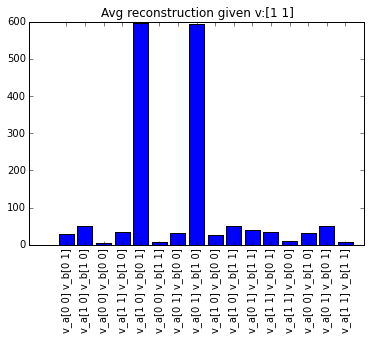

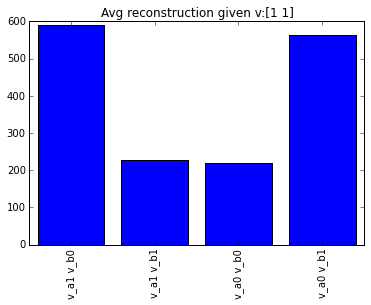

In [89]:
plot_avg_results_for_visible_pattern(np.array([1,1]), a)
plot_avg_results_for_visible_pattern(np.array([1,1]), WrappedVanillaSampler(dot))

# Yussssssssss#
This is perfect, over all cases for the visible pattern it can separate it. Creating excellent reconstructions the majority of the time. We already know the vanilla RBM will fail to do this. Still i graphed the output of on of the visible reconstructions of the vanilla. 

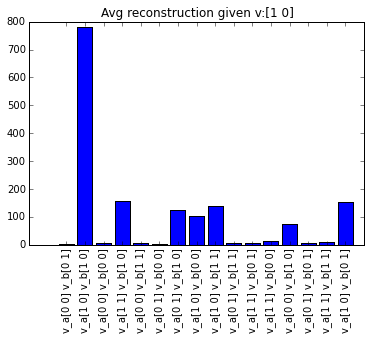

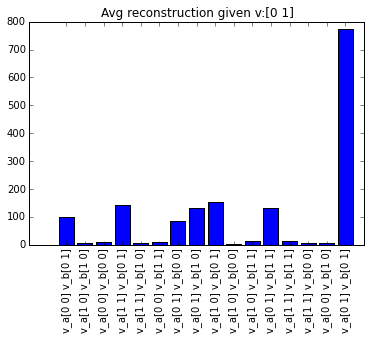

In [79]:
plot_avg_results_for_visible_pattern(np.array([1,0]), a)
plot_avg_results_for_visible_pattern(np.array([0,1]), a)

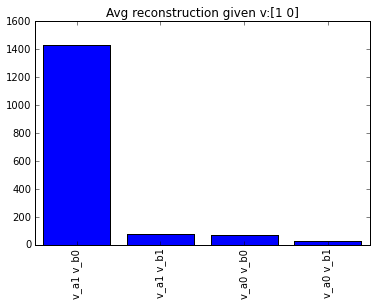

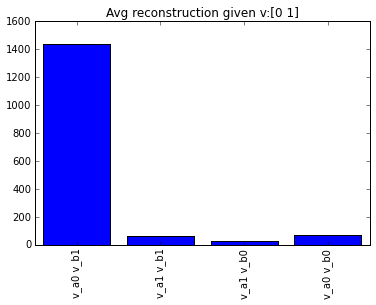

In [90]:
plot_avg_results_for_visible_pattern(np.array([1,0]), WrappedVanillaSampler(dot))
plot_avg_results_for_visible_pattern(np.array([0,1]), WrappedVanillaSampler(dot))